# Description

In this notebook i will create predictive models to classification of pneumonia using neural network based learning methods. The following machine learning neural network methods are used to do this: 

Convolutional neural network based learning [1] (http://shorturl.at/EHW08): This technique was used to predict if an patient has pneumonia based on his chest xraw image.

Convolutional Autoencoders neural network based learning [2] (http://shorturl.at/fI129): This technique was used to make image color palette distribution off normal chest xraw images different from chest xraw images of patients with pneumonia.

The kaggle https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia dataset was used to train the algoritms. The folder data_pre_processing.ipynb contains the pre-processing step.

[1] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).

[2] Chen, M., Shi, X., Zhang, Y., Wu, D., & Guizani, M. (2017). Deep features learning for medical image analysis with convolutional autoencoder neural network. IEEE Transactions on Big Data.

# Mount drive and imports

In [0]:
!pip install -U keras==2.3.0

     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
# on google colab only

import os
import seaborn as sns
from google.colab import drive

drive.mount("/drive")
os.chdir("/drive/My Drive/Projects/Pneumonia detection")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import np_utils

Using TensorFlow backend.


# Functions

In [0]:
def show_images_grid(w, h, *images, **fig_kwargs):
  fig = plt.figure(**fig_kwargs)
  cont = 1
  
  for image in images:
    if len(image.shape) == 3 and image.shape[-1] == 1:
      image = image.reshape(*image.shape[:2])
    fig.add_subplot(w, h, cont).imshow(image)
    
    cont+=1

# Load data

In [0]:
dataset_train_normal_512x512 = np.load("dataset/dataset_train_normal_512x512.npy")
dataset_train_pneumonia_virus_512x512 = np.load("dataset/dataset_train_pneumonia_virus_512x512.npy")
dataset_train_pneumonia_bacteria_512x512 = np.load("dataset/dataset_train_pneumonia_bacteria_512x512.npy")

dataset_test_normal_512x512 = np.load("dataset/dataset_test_normal_512x512.npy")
dataset_test_pneumonia_virus_512x512 = np.load("dataset/dataset_test_pneumonia_virus_512x512.npy")
dataset_test_pneumonia_bacteria_512x512 = np.load("dataset/dataset_test_pneumonia_bacteria_512x512.npy")

In [0]:
print(f"Normal dataset train size: {len(dataset_train_normal_512x512)}")
print(f"Virus dataset train size: {len(dataset_train_pneumonia_virus_512x512)}")
print(f"bacteria dataset train size: {len(dataset_train_pneumonia_bacteria_512x512)}")
print()
print(f"Normal dataset test size: {len(dataset_test_normal_512x512)}")
print(f"Virus dataset test size: {len(dataset_test_pneumonia_virus_512x512)}")
print(f"bacteria dataset test size: {len(dataset_test_pneumonia_bacteria_512x512)}")

Normal dataset train size: 1341
Virus dataset train size: 1345
bacteria dataset train size: 2530

Normal dataset test size: 234
Virus dataset test size: 148
bacteria dataset test size: 242


# Pre-processing data

In [0]:
img_w, img_h = 64, 64
img_size = (64, 64)
chanels = 1

In [0]:
from functools import partial

def pre_processing(imgs_arr, img_size, norm = True):
  imgs_arr = np.array([np.array(Image.fromarray(img_arr).resize(img_size)) for img_arr in imgs_arr])
  if norm:
    imgs_arr = imgs_arr/255
  
  imgs_arr = np.reshape(imgs_arr, (len(imgs_arr), *img_size, 1))
  
  return imgs_arr


pre_processing_w = partial(pre_processing, img_size = img_size, norm = True)

normal_train = pre_processing_w(dataset_train_normal_512x512)
virus_train = pre_processing_w(dataset_train_pneumonia_virus_512x512)
bacteria_train = pre_processing_w(dataset_train_pneumonia_bacteria_512x512)

normal_test = pre_processing_w(dataset_test_normal_512x512)
virus_test = pre_processing_w(dataset_test_pneumonia_virus_512x512)
bacteria_test = pre_processing_w(dataset_test_pneumonia_bacteria_512x512)

# Train Conv Autoencoder

In [0]:
input_img = Input(shape=(64, 64, 1))  

############
# Encoding #
############

# Conv1 #
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

############
# Decoding #
############

# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 8, 8, 8)           0  

In [0]:
autoencoder.fit(normal_train, normal_train,
                epochs=40,
                batch_size=64,
                shuffle=True,
                )

Epoch 1/40
1341/1341 [==============================] - 1s 420us/step - loss: 0.6825
Epoch 2/40
1341/1341 [==============================] - 0s 135us/step - loss: 0.6371
Epoch 3/40
1341/1341 [==============================] - 0s 134us/step - loss: 0.6091
Epoch 4/40
1341/1341 [==============================] - 0s 134us/step - loss: 0.5968
Epoch 5/40
1341/1341 [==============================] - 0s 134us/step - loss: 0.5900
Epoch 6/40
1341/1341 [==============================] - 0s 137us/step - loss: 0.5853
Epoch 7/40
1341/1341 [==============================] - 0s 135us/step - loss: 0.5821
Epoch 8/40
1341/1341 [==============================] - 0s 136us/step - loss: 0.5801
Epoch 9/40
1341/1341 [==============================] - 0s 132us/step - loss: 0.5786
Epoch 10/40
1341/1341 [==============================] - 0s 132us/step - loss: 0.5770
Epoch 11/40
1341/1341 [==============================] - 0s 136us/step - loss: 0.5759
Epoch 12/40
1341/1341 [==============================] - 0s 133

In [0]:
# Calculate error

error_test_imgs_normal = [img for img in np.abs(normal_test - autoencoder.predict(normal_test))]
error_test_imgs_virus = [img for img in np.abs(virus_test - autoencoder.predict(virus_test))]
error_test_imgs_bacteria = [img for img in np.abs(bacteria_test - autoencoder.predict(bacteria_test))]

## show Images error

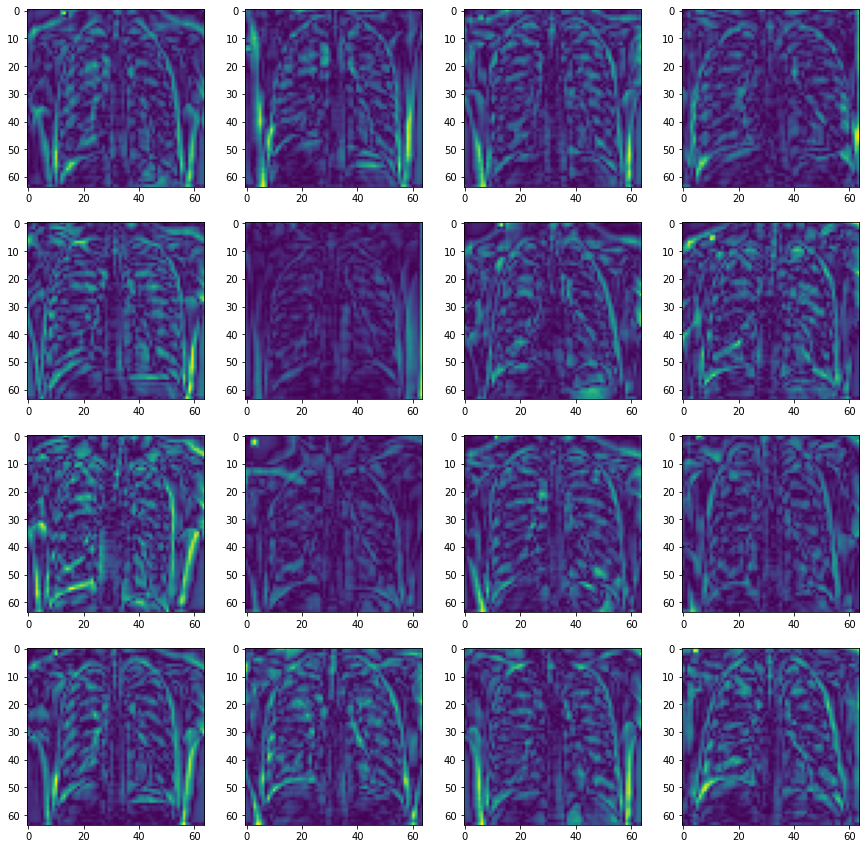

In [0]:
# normal images

show_images_grid(4, 4, *error_test_imgs_normal[:16], figsize = (15, 15))

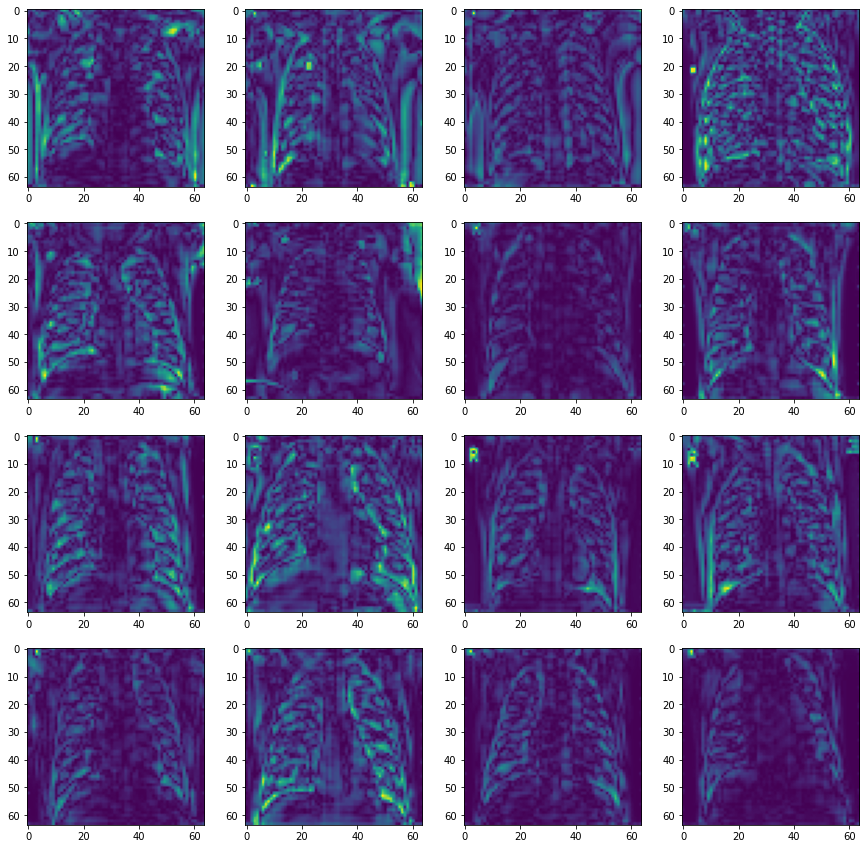

In [0]:
# virus images

show_images_grid(4, 4, *error_test_imgs_virus[:16], figsize = (15, 15))

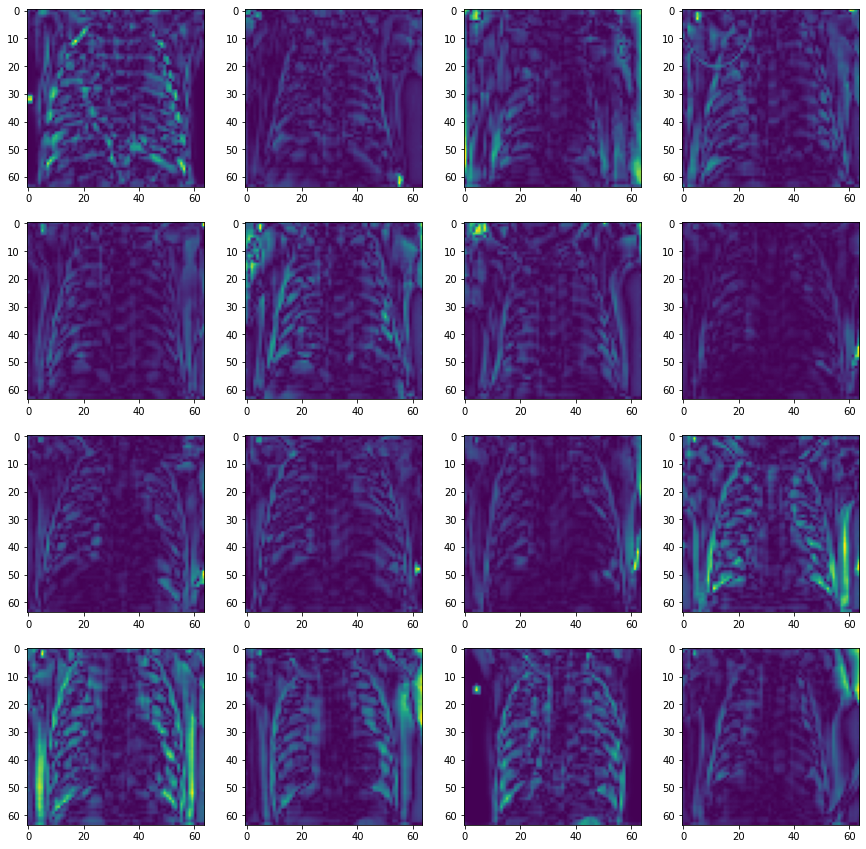

In [0]:
# bacteria image

show_images_grid(4, 4, *error_test_imgs_bacteria[:16], figsize = (15, 15))

## Show histogram errors

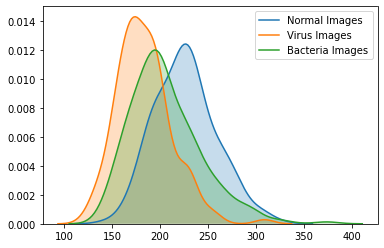

In [0]:
error_sum_test_imgs_normal = np.array([img.sum() for img in error_test_imgs_normal])
error_sum_test_imgs_virus = np.array([img.sum() for img in error_test_imgs_virus])
error_sum_test_imgs_bacteria = np.array([img.sum() for img in error_test_imgs_bacteria])

sns.kdeplot(error_sum_test_imgs_normal, shade=True, label = "Normal Images")
sns.kdeplot(error_sum_test_imgs_virus, shade=True, label = "Virus Images")
sns.kdeplot(error_sum_test_imgs_bacteria, shade=True, label = "Bacteria Images")

# Train Conv Classifier

In [0]:
def get_train_test(with_pneumonia_type = False, use_autoencoder = False):
  if use_autoencoder:
    normal_train_ = autoencoder.predict(normal_train)
    virus_train_ = autoencoder.predict(virus_train)
    bacteria_train_ = autoencoder.predict(bacteria_train)
    normal_test_ = autoencoder.predict(normal_test)
    virus_test_ = autoencoder.predict(virus_test)
    bacteria_test_ = autoencoder.predict(bacteria_test)
  else:
    normal_train_ = normal_train
    virus_train_ = virus_train
    bacteria_train_ = bacteria_train
    normal_test_ = normal_test
    virus_test_ = virus_test
    bacteria_test_ = bacteria_test
  
  trainX = np.concatenate([normal_train_, virus_train_, bacteria_train_])
  testX = np.concatenate([normal_test_, virus_test_, bacteria_test_])
  if with_pneumonia_type:
    num_category = 3
    trainY = [0] * len(normal_train) + [1] * len(virus_train) + [2] * len(bacteria_train)
    testY = [0] * len(normal_test) + [1] * len(virus_test) + [2] * len(bacteria_test)
    trainY = np_utils.to_categorical(trainY)
    testY = np_utils.to_categorical(testY)
  else:
    num_category = 2
    trainY = [0] * len(normal_train) + [1] * (len(virus_train) + len(bacteria_train))
    testY = [0] * len(normal_test) + [1] * (len(virus_test) + len(bacteria_test))
    trainY = np_utils.to_categorical(trainY)
    testY = np_utils.to_categorical(testY)
  
  return trainX, trainY, testX, testY, num_category

In [0]:
#@title build cnn
import keras
from keras.models import Sequential
from keras.layers import *

##model building
def create_model(num_category, img_w=64, img_h=64, chanels=1):

  model = Sequential()
  #convolutional layer with rectified linear unit activation
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(img_w, img_h, chanels)))
  #32 convolution filters used each of size 3x3
  #again
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  #64 convolution filters used each of size 3x3
  #choose the best features via pooling
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #randomly turn neurons on and off to improve convergence
  #model.add(Dropout(0.25))
  #flatten since too many dimensions, we only want a classification output
  model.add(Flatten())
  #fully connected to get all relevant data
  model.add(Dense(128, activation='relu'))
  #one more dropout for convergence' sake :) 
  #output a softmax to squash the matrix into output probabilities
  model.add(Dense(num_category, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  
  return model

In [0]:
def train(trainX, trainY, testX, testY, model):
  batch_size = 128
  num_epoch = 10
  #model training
  model_log = model.fit(trainX, trainY,
            batch_size=batch_size,
            epochs=num_epoch,
            verbose=1,
            validation_data=(testX, testY))
  
  return model_log

In [0]:
# train model that predict pneumonia type (virus, bacteria) and without autoencoder data # Acuracy val avg 0.667

trainX, trainY, testX, testY, num_category = get_train_test(with_pneumonia_type = True, use_autoencoder = False)
model = create_model(num_category)
model_log_with_pneumonia_type = train(trainX, trainY, testX, testY, model)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 20s 4ms/step - loss: 1.3488 - accuracy: 0.4797 - val_loss: 0.9107 - val_accuracy: 0.6779
Epoch 2/10
5216/5216 [==============================] - 20s 4ms/step - loss: 0.9074 - accuracy: 0.5874 - val_loss: 1.1168 - val_accuracy: 0.4487
Epoch 3/10
5216/5216 [==============================] - 21s 4ms/step - loss: 0.7523 - accuracy: 0.6580 - val_loss: 0.7295 - val_accuracy: 0.7163
Epoch 4/10
5216/5216 [==============================] - 20s 4ms/step - loss: 0.6494 - accuracy: 0.7276 - val_loss: 0.6811 - val_accuracy: 0.7532
Epoch 5/10
5216/5216 [==============================] - 20s 4ms/step - loss: 0.5525 - accuracy: 0.7613 - val_loss: 1.3876 - val_accuracy: 0.5497
Epoch 6/10
5216/5216 [==============================] - 20s 4ms/step - loss: 0.5259 - accuracy: 0.7676 - val_loss: 0.9991 - val_accuracy: 0.6362
Epoch 7/10
5216/5216 [==============================] - 20s 4ms/step - loss: 0.5118

In [0]:
# train model without predict pneumonia type (virus, bacteria) and without autoencoder data # Acuracy val avg 0.75

trainX, trainY, testX, testY, num_category = get_train_test(with_pneumonia_type = False, use_autoencoder = False)
model = create_model(num_category)
model_log_without_pneumonia_type = train(trainX, trainY, testX, testY, model)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 3s 519us/step - loss: 0.5994 - accuracy: 0.7460 - val_loss: 1.4048 - val_accuracy: 0.6250
Epoch 2/10
5216/5216 [==============================] - 2s 386us/step - loss: 0.4423 - accuracy: 0.8225 - val_loss: 0.4297 - val_accuracy: 0.7821
Epoch 3/10
5216/5216 [==============================] - 2s 387us/step - loss: 0.2912 - accuracy: 0.8773 - val_loss: 0.4879 - val_accuracy: 0.7804
Epoch 4/10
5216/5216 [==============================] - 2s 386us/step - loss: 0.1734 - accuracy: 0.9302 - val_loss: 0.8138 - val_accuracy: 0.7292
Epoch 5/10
5216/5216 [==============================] - 2s 387us/step - loss: 0.1852 - accuracy: 0.9248 - val_loss: 0.7840 - val_accuracy: 0.7436
Epoch 6/10
5216/5216 [==============================] - 2s 387us/step - loss: 0.1296 - accuracy: 0.9519 - val_loss: 1.1177 - val_accuracy: 0.7003
Epoch 7/10
5216/5216 [==============================] - 2s 386us/step - loss:

In [0]:
# train model that predict pneumonia type (virus, bacteria) and with autoencoder data # Acuracy val avg 0.66

trainX, trainY, testX, testY, num_category = get_train_test(with_pneumonia_type = True, use_autoencoder = True)
model = create_model(num_category)
model_log = train(trainX, trainY, testX, testY, model)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 25s 5ms/step - loss: 1.2170 - accuracy: 0.4795 - val_loss: 1.1535 - val_accuracy: 0.3878
Epoch 2/10
5216/5216 [==============================] - 16s 3ms/step - loss: 1.0375 - accuracy: 0.4659 - val_loss: 0.9296 - val_accuracy: 0.6651
Epoch 3/10
5216/5216 [==============================] - 16s 3ms/step - loss: 0.9156 - accuracy: 0.5721 - val_loss: 0.7945 - val_accuracy: 0.7131
Epoch 4/10
5216/5216 [==============================] - 16s 3ms/step - loss: 0.7803 - accuracy: 0.6630 - val_loss: 0.7483 - val_accuracy: 0.7019
Epoch 5/10
5216/5216 [==============================] - 15s 3ms/step - loss: 0.6344 - accuracy: 0.7193 - val_loss: 0.8635 - val_accuracy: 0.6779
Epoch 6/10
5216/5216 [==============================] - 16s 3ms/step - loss: 0.5924 - accuracy: 0.7391 - val_loss: 0.9777 - val_accuracy: 0.6138
Epoch 7/10
5216/5216 [==============================] - 16s 3ms/step - loss: 0.5823

In [0]:
# train model without predict pneumonia type (virus, bacteria) and with autoencoder data # Acuracy val avg 0.75

trainX, trainY, testX, testY, num_category = get_train_test(with_pneumonia_type = False, use_autoencoder = True)
model = create_model(num_category)
model_log = train(trainX, trainY, testX, testY, model)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.6766 - accuracy: 0.7205 - val_loss: 0.6238 - val_accuracy: 0.6250
Epoch 2/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.5009 - accuracy: 0.7736 - val_loss: 0.5198 - val_accuracy: 0.7324
Epoch 3/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.4020 - accuracy: 0.8094 - val_loss: 0.9258 - val_accuracy: 0.6587
Epoch 4/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.3516 - accuracy: 0.8489 - val_loss: 1.1485 - val_accuracy: 0.6314
Epoch 5/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.3243 - accuracy: 0.8786 - val_loss: 0.5645 - val_accuracy: 0.7324
Epoch 6/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.2031 - accuracy: 0.9222 - val_loss: 0.4492 - val_accuracy: 0.8109
Epoch 7/10
5216/5216 [==============================] - 8s 2ms/step - loss: 0.1739 - accu

# Acurracy barplot

In [0]:
dataset = pd.DataFrame({"Com previsão do tipo": model_log_with_pneumonia_type.history["val_accuracy"], "Sem previsão do tipo": model_log_without_pneumonia_type.history["val_accuracy"]})
dataset = dataset.melt(value_vars=["Com previsão do tipo", "Sem previsão do tipo"], var_name="Tipo", value_name="Value")

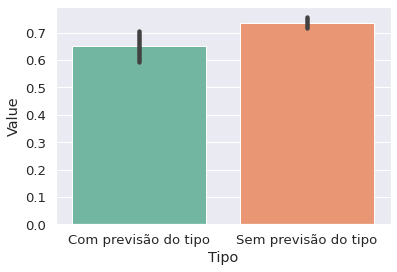

In [0]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette("Set2"))

sns.barplot(data = dataset, x = "Tipo", y = "Value")